In [ ]:
#Import modules
import numpy as np 
import pandas as pd
import seaborn as sns
import nltk
import string
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#Download necessary nltk modules | natural lang took kit
nltk.download('stopwords')
nltk.download('wordnet')

# Import libraries from Scikit-learn for LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

#Import TensorFlow/Keras for the Bidirectional LSTM network
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Import plotting libraries
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/louiss/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/louiss/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
#Full path to the CSV file
def load_data():
    data = pd.read_csv('sentimentDatabase.csv', sep=',', encoding='latin-1',names = ["sentiment","headline"])
    return data
data_record = load_data()
data_record.head(6)

,sentiment,headline
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...
5,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...


[Text(0, 0, '1363')]

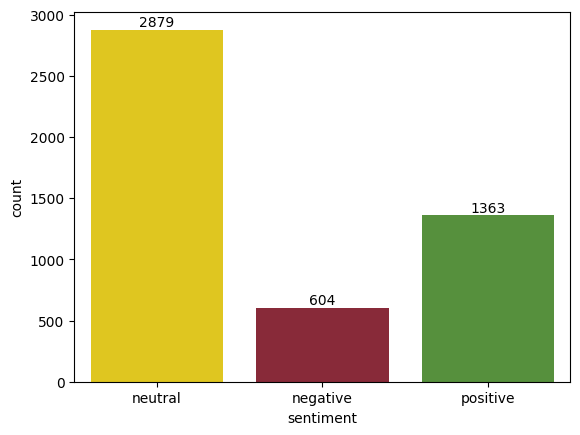

In [22]:
#Text visualisation
countplot = sns.countplot(x="sentiment",data=data_record, hue="sentiment", palette=['#FFDE00',"#971B2F","#509E2F"],legend=False)
countplot.bar_label(countplot.containers[0])
countplot.bar_label(countplot.containers[1])
countplot.bar_label(countplot.containers[2])

In [23]:
# Remove punctuations
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

data_record['headline'] = data_record['headline'].apply(lambda x: remove_punct(x))


In [24]:
# Remove stop words
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

data_record["after_stopwords"] = data_record["headline"].apply(lambda text: remove_stopwords(text))

In [25]:
# Stemming
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])
data_record["after_stemmed"] = data_record["after_stopwords"].apply(lambda text: stem_words(text))

In [26]:
# Remove frequent words
count = Counter()
for text in data_record["after_stemmed"].values:
    for word in text.split():
        count[word] += 1
freq_words = set([w for (w, wc) in count.most_common(12)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in freq_words])

data_record["after_removedFreq"] = data_record["after_stemmed"].apply(lambda text: remove_freqwords(text))

In [27]:
# Lemmatization
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(word) for word in w_tokenizer.tokenize(text)])
data_record["after_lemmatisation"] = data_record.after_removedFreq.apply(lemmatize_text)

In [28]:
# Label encoding
data_record['predicted_sentiment'] = LabelEncoder().fit_transform(data_record['sentiment'])

# Drop unnecessary columns
data_record = data_record.drop(["after_stopwords", "after_stemmed", "sentiment", "headline", "after_removedFreq"], axis=1)


In [29]:
# Split dataset
x_train, x_test, y_train, y_test = train_test_split(data_record['after_lemmatisation'], data_record['predicted_sentiment'], test_size=0.3, random_state=0)

# TextVectorization for LSTM
max_tokens = 10000
max_length = 100

# Create and fit TextVectorization layer
vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=max_length)
vectorizer.adapt(x_train.values)

x_train_sequences = vectorizer(x_train)
x_test_sequences = vectorizer(x_test)

x_train_padded = np.array(x_train_sequences)
x_test_padded = np.array(x_test_sequences)

y_train = np.array(y_train)
y_test = np.array(y_test)

In [39]:
# Custom Callback to track performance metrics for LSTM
class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epoch_acc = []
        self.epoch_precision = []
        self.epoch_recall = []
        self.epoch_loss = []

    def on_epoch_end(self, epoch, logs=None):
        val_pred = np.argmax(self.model.predict(x_test_padded), axis=1)
        val_true = y_test
        acc = accuracy_score(val_true, val_pred)
        precision = precision_score(val_true, val_pred, average='weighted', zero_division=0)
        recall = recall_score(val_true, val_pred, average='weighted', zero_division=0)
        loss = logs['val_loss']
        self.epoch_acc.append(acc)
        self.epoch_precision.append(precision)
        self.epoch_recall.append(recall)
        self.epoch_loss.append(loss)
        print(f"\nEpoch {epoch+1} - Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, Loss: {loss:.4f}")

In [41]:
# Build Bidirectional LSTM model
lstm_model = Sequential([
    Embedding(input_dim=max_tokens, output_dim=128),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback with more patience (5 epochs)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Custom MetricsCallback
metrics_callback = MetricsCallback()

# Train the LSTM model for 10 epochs
history = lstm_model.fit(
    x_train_padded, y_train,
    validation_data=(x_test_padded, y_test),
    epochs=10,  # Set epochs to 10
    batch_size=64,
    callbacks=[early_stopping, metrics_callback],
    verbose=1
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5557

Epoch 1 - Accuracy: 0.6045, Precision: 0.3655, Recall: 0.6045, Loss: 0.8742
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - accuracy: 0.5562 - loss: 0.9844 - val_accuracy: 0.6045 - val_loss: 0.8742
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  - accuracy: 0.6338 -

Epoch 2 - Accuracy: 0.6933, Precision: 0.5974, Recall: 0.6933, Loss: 0.7076
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.6346 - loss: 0.8128 - val_accuracy: 0.6933 - val_loss: 0.7076
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/stepp - accuracy: 0.8072 - 

Epoch 3 - Accuracy: 0.7352, Precision: 0.7263, Recall: 0.7352, Loss: 0.7239
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 0.8076 - loss: 0.4892 - val_accuracy: 0.7352 - val_loss: 0.7239
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/stepp - accuracy: 0.9150 - 

Epoch 4 - Accuracy: 0.7249, Precision: 0.7219, Recall: 0.7249, Loss: 0.8631
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 

In [14]:
# Track metrics for LinearSVC manually
svc_metrics = {
    'accuracy': [],
    'precision': [],
    'recall': []
}

# Simulate epochs by fitting LinearSVC and collecting metrics
for epoch in range(1, 8+1):  # Simulate 10 epochs
    # LinearSVC Model
    svc_pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('svc', LinearSVC(max_iter=epoch, loss='hinge'))
    ])
    svc_pipeline.fit(x_train, y_train)
    y_pred_svc = svc_pipeline.predict(x_test)
    acc = accuracy_score(y_test, y_pred_svc)
    precision = precision_score(y_test, y_pred_svc, average='weighted')
    recall = recall_score(y_test, y_pred_svc, average='weighted')
    svc_metrics['accuracy'].append(acc)
    svc_metrics['precision'].append(precision)
    svc_metrics['recall'].append(recall)
    print(f"Epoch {epoch:2} - SVC Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")


Epoch  1 - SVC Accuracy: 0.7091, Precision: 0.7345, Recall: 0.7091
Epoch  2 - SVC Accuracy: 0.7043, Precision: 0.7219, Recall: 0.7043
Epoch  3 - SVC Accuracy: 0.7393, Precision: 0.7353, Recall: 0.7393
Epoch  4 - SVC Accuracy: 0.7517, Precision: 0.7464, Recall: 0.7517
Epoch  5 - SVC Accuracy: 0.7435, Precision: 0.7382, Recall: 0.7435


/Users/louiss/VSC Files/CS EE - ML Sentiment Analysis/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louiss/VSC Files/CS EE - ML Sentiment Analysis/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louiss/VSC Files/CS EE - ML Sentiment Analysis/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louiss/VSC Files/CS EE - ML Sentiment Analysis/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louiss/VSC Files/CS EE - ML Sentiment Analysis/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceW

Epoch  6 - SVC Accuracy: 0.7503, Precision: 0.7435, Recall: 0.7503
Epoch  7 - SVC Accuracy: 0.7510, Precision: 0.7464, Recall: 0.7510
Epoch  8 - SVC Accuracy: 0.7552, Precision: 0.7484, Recall: 0.7552


/Users/louiss/VSC Files/CS EE - ML Sentiment Analysis/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/louiss/VSC Files/CS EE - ML Sentiment Analysis/myenv/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


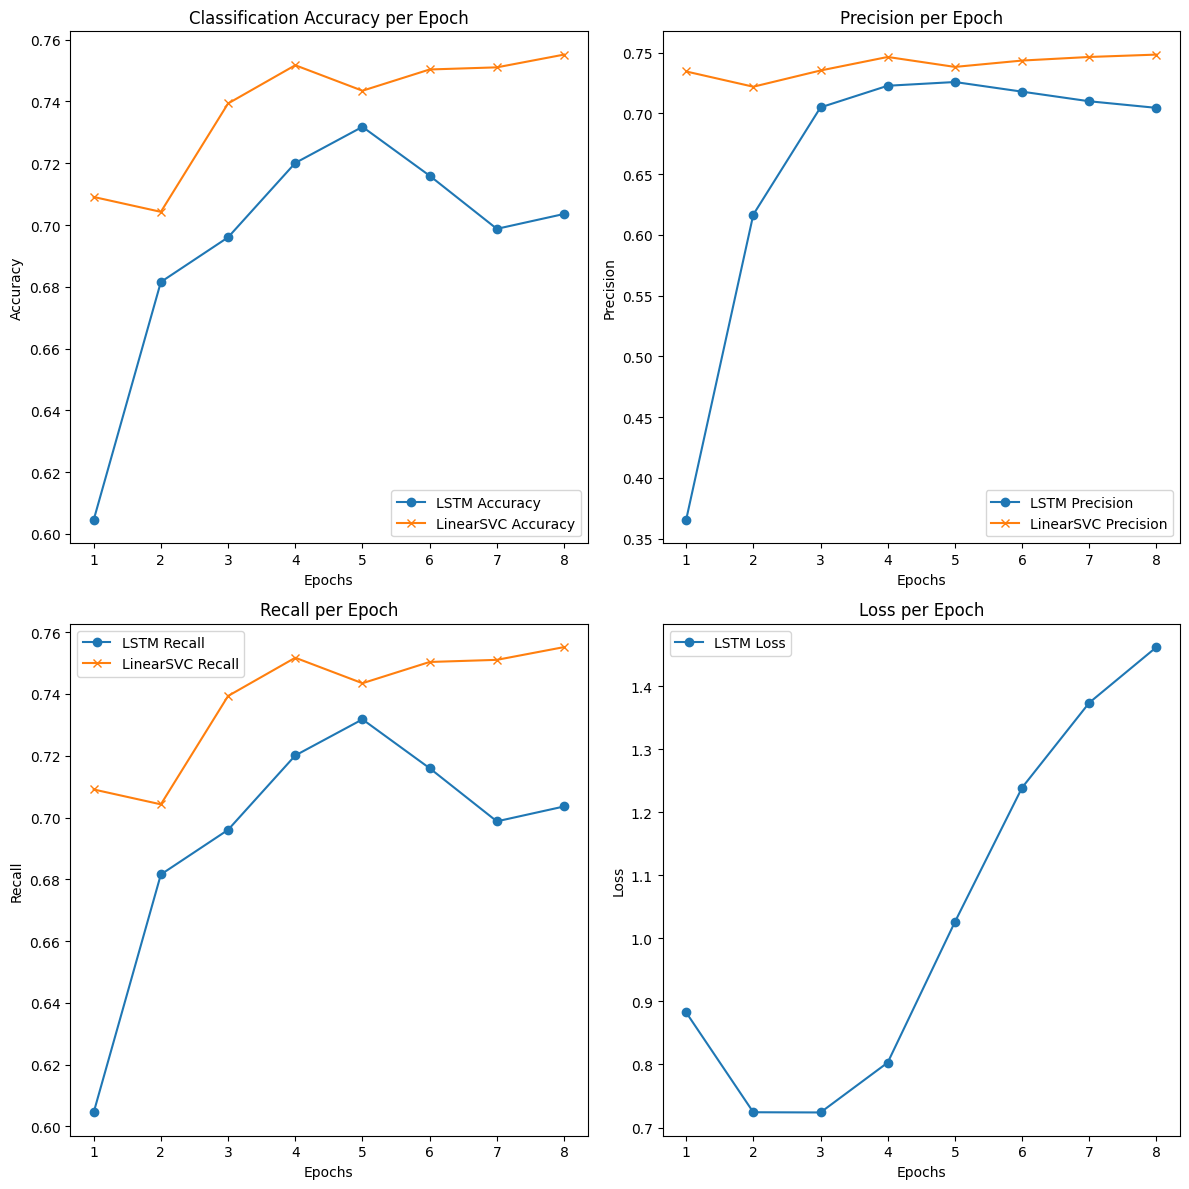

In [15]:
# Set the number of epochs (already fixed to 8 for both models)
epochs = range(1, 9)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Accuracy plot
axes[0, 0].plot(epochs, metrics_callback.epoch_acc, label='LSTM Accuracy', marker='o')
axes[0, 0].plot(epochs, svc_metrics['accuracy'], label='LinearSVC Accuracy', marker='x')
axes[0, 0].set_title('Classification Accuracy per Epoch')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Precision plot
axes[0, 1].plot(epochs, metrics_callback.epoch_precision, label='LSTM Precision', marker='o')
axes[0, 1].plot(epochs, svc_metrics['precision'], label='LinearSVC Precision', marker='x')
axes[0, 1].set_title('Precision per Epoch')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()

# Recall plot
axes[1, 0].plot(epochs, metrics_callback.epoch_recall, label='LSTM Recall', marker='o')
axes[1, 0].plot(epochs, svc_metrics['recall'], label='LinearSVC Recall', marker='x')
axes[1, 0].set_title('Recall per Epoch')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].legend()

# Loss plot (only for LSTM)
axes[1, 1].plot(epochs, metrics_callback.epoch_loss, label='LSTM Loss', marker='o')
axes[1, 1].set_title('Loss per Epoch')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


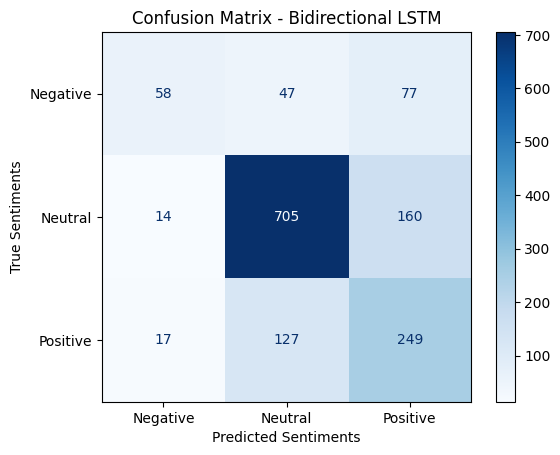

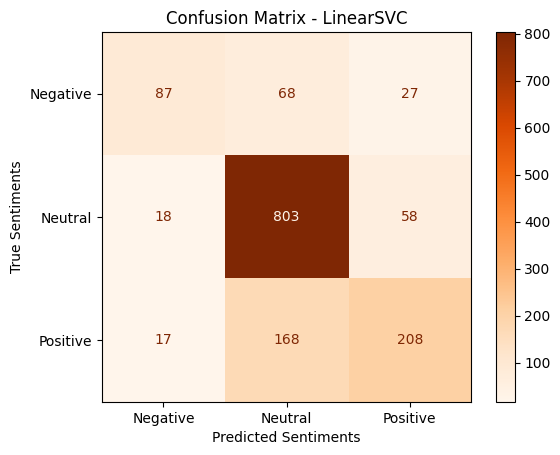

In [22]:
# Confusion Matrix Visualization for Both Models using ConfusionMatrixDisplay
# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# LSTM Confusion Matrix
lstm_confusion_matrix = confusion_matrix(y_test, np.argmax(lstm_model.predict(x_test_padded), axis=1))
disp_lstm = ConfusionMatrixDisplay(confusion_matrix=lstm_confusion_matrix, display_labels=sentiment_labels)
disp_lstm.plot(cmap="Blues")
plt.title('Confusion Matrix - Bidirectional LSTM')
plt.xlabel('Predicted Sentiments')
plt.ylabel('True Sentiments')
plt.show()

# LinearSVC Confusion Matrix
svc_confusion_matrix = confusion_matrix(y_test, svc_pipeline.predict(x_test))
disp_svc = ConfusionMatrixDisplay(confusion_matrix=svc_confusion_matrix, display_labels=sentiment_labels)
disp_svc.plot(cmap="Oranges")
plt.title('Confusion Matrix - LinearSVC')
plt.xlabel('Predicted Sentiments')
plt.ylabel('True Sentiments')
plt.show()

LSTM Model: TP: [ 58 705 249], TN: [1241  401  824], FP: [ 31 174 237], FN: [124 174 144]
LinearSVC Model: TP: [ 87 803 208], TN: [1237  339  976], FP: [ 35 236  85], FN: [ 95  76 185]
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


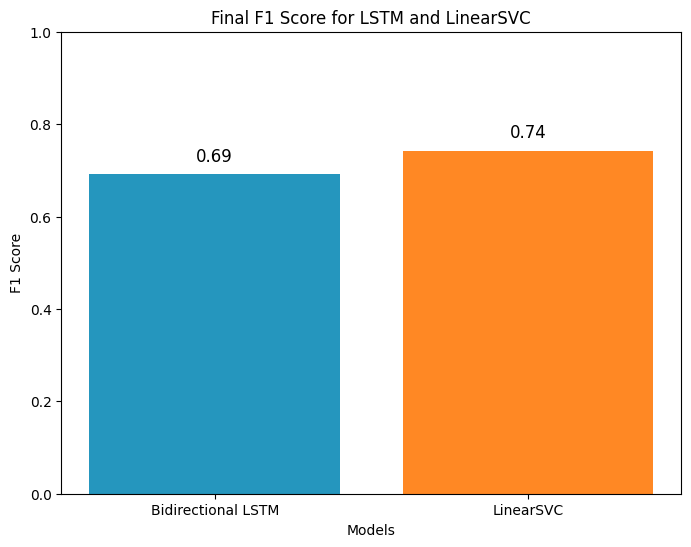

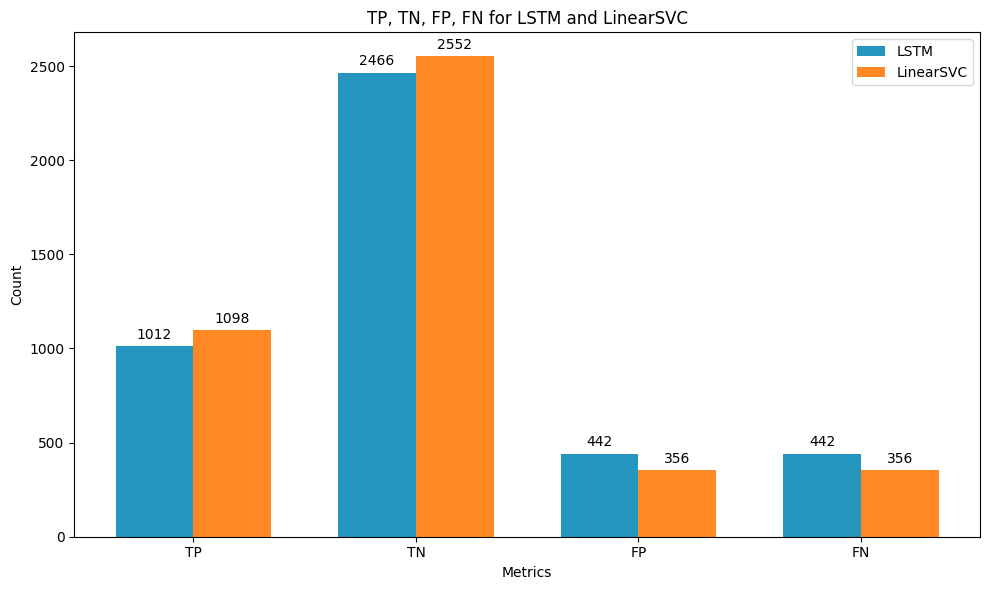

In [24]:
# Extract TP, TN, FP, FN for both models from the confusion matrix
def calculate_tp_tn_fp_fn(conf_matrix):
    TP = np.diag(conf_matrix)
    FN = np.sum(conf_matrix, axis=1) - TP
    FP = np.sum(conf_matrix, axis=0) - TP
    TN = np.sum(conf_matrix) - (FP + FN + TP)
    return TP, TN, FP, FN

# LSTM TP, TN, FP, FN
TP_lstm, TN_lstm, FP_lstm, FN_lstm = calculate_tp_tn_fp_fn(lstm_confusion_matrix)
print(f"LSTM Model: TP: {TP_lstm}, TN: {TN_lstm}, FP: {FP_lstm}, FN: {FN_lstm}")

# LinearSVC TP, TN, FP, FN
TP_svc, TN_svc, FP_svc, FN_svc = calculate_tp_tn_fp_fn(svc_confusion_matrix)
print(f"LinearSVC Model: TP: {TP_svc}, TN: {TN_svc}, FP: {FP_svc}, FN: {FN_svc}")

# Bar chart for final F1 scores
lstm_f1 = f1_score(y_test, np.argmax(lstm_model.predict(x_test_padded), axis=1), average='weighted')
svc_f1 = f1_score(y_test, svc_pipeline.predict(x_test), average='weighted')

plt.figure(figsize=(8, 6))
bars= plt.bar(['Bidirectional LSTM', 'LinearSVC'], [lstm_f1, svc_f1], color=['#2596be', '#ff8824'])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=12)
plt.title('Final F1 Score for LSTM and LinearSVC')
plt.xlabel('Models')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

# Bar chart for TP, TN, FP, FN of both models
metrics_labels = ['TP', 'TN', 'FP', 'FN']
lstm_metrics = [TP_lstm.sum(), TN_lstm.sum(), FP_lstm.sum(), FN_lstm.sum()]
svc_metrics = [TP_svc.sum(), TN_svc.sum(), FP_svc.sum(), FN_svc.sum()]

x = np.arange(len(metrics_labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, lstm_metrics, width, label='LSTM', color='#2596be')
rects2 = ax.bar(x + width/2, svc_metrics, width, label='LinearSVC', color='#ff8824')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Count')
ax.set_title('TP, TN, FP, FN for LSTM and LinearSVC')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

# Annotate bars with counts
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()